In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
from ast import literal_eval

import metpy.calc as mcalc
import metpy.units as munits

import itertools
import datetime
import copy
import sys  
import glob
import random
import time

sys.path.insert(0, '../../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_metrics as metrics
from soundings.preprocessing import dataloader as dl
from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot

VOL = '/mnt/data1/stock/mlsoundings'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Tue May  4 15:41:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   32C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000

In [6]:
container = np.load(os.path.join(VOL, 'preprocessed_alley.npz'))

raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

container.close()

print(raob.shape, rap.shape, goes.shape, rtma.shape)

(38373, 256, 4) (38373, 256, 4) (38373, 3, 3, 8) (38373, 3, 3, 3)


In [7]:
def compute_tpw_metpy(pressure, dewpoint):
    pressure *= munits.units.hPa
    dewpoint *= munits.units.degC
    return mcalc.precipitable_water(dewpoint, pressure).magnitude

def compute_tpw(pressure, dewpoint):
    """
    References:
        Salby, M. L., 1996: Fundamentals of Atmospheric Physics. Academic Press, 627 pp.
    Saturation Vapor Pressure:
        .. math:: 6.112\;exp(\frac{17.67\;T}{T + 243.5})
    Mixing Ratio:
        .. math:: \epsilon \frac{e}{p - e}
    Total Precipitable Water:
        .. math::  -\frac{1}{\rho_l g} \int\limits_{p_\text{bottom}}^{p_\text{top}} r dp
        
    Note: current implementation uses a different value of dry_air_molecular_weight as compared
          to '0.12.2' version of metpy. this def uses the value specified in:
          Picard, A., R. S. Davis, M. Gläser, and K. Fujii, 2008: Revised formula for the density 
          of moist air (CIPM-2007), Metrologia, 45, No. 2, doi: 10.1088/0026-1394/45/2/004.
    """
    #!! A. compute saturation vapor pressure
    sat_pressure_0c = 6.112
    saturation_vapor_pressure = sat_pressure_0c * np.exp(17.67 * (dewpoint) / (dewpoint + 243.5))

    #!! B. compute mixing ratio
    water_molecular_weight   = Mw = 18.015268 # (g/mol)
    # Revised formula for the density of moist air (CIPM-2007) A Picard
    dry_air_molecular_weight = Md = 28.96546e-3 * 1000 # (kg/mol) 
    molecular_weight_ratio   = Mw / Md
    mixing_ratio = (molecular_weight_ratio * saturation_vapor_pressure / (pressure - saturation_vapor_pressure))
    
    #!! C. compute total precipitable water
    # since pressure is in decreasing order, pw will be the opposite sign of that expected.
    # covert hectopascal meter2 second2/kilogram to mm
    earth_gravity = g     = 9.80665 # 'm / s^2'
    density_water = rho_l = 999.97495 # 'kg / m^3'
    return -np.trapz(mixing_ratio, pressure) / (g * rho_l) * 100000 

In [11]:
i = 105

pressure = raob[i, :, dl.PRESSURE]
temperature = raob[i, :, dl.TEMPERATURE]
dewpoint = raob[i, :, dl.DEWPOINT]

print(f'Precipitable Water: metpy: {compute_tpw_metpy(pressure, dewpoint):.5f}, custom: {compute_tpw(pressure, dewpoint):.5f}')

Precipitable Water: metpy: 13.16365, custom: 13.16349


In [12]:
for i in range(7):
    a = compute_tpw(raob[i, :, dl.PRESSURE], raob[i, :, dl.DEWPOINT])
    b = compute_tpw(rap[i, :, dl.PRESSURE], rap[i, :, dl.DEWPOINT])
    print(f'RAOB: {a:.5f}, RAP: {b:.5f}, Difference: {a-b:.5f}')

RAOB: 2.39553, RAP: 2.95084, Difference: -0.55530
RAOB: 2.45496, RAP: 2.88105, Difference: -0.42609
RAOB: 4.14531, RAP: 4.15911, Difference: -0.01380
RAOB: 3.00808, RAP: 3.25646, Difference: -0.24838
RAOB: 3.81926, RAP: 3.86382, Difference: -0.04457
RAOB: 5.22990, RAP: 5.20723, Difference: 0.02268
RAOB: 6.41745, RAP: 7.61475, Difference: -1.19730


In [ ]:
def timetest():
    i = np.randint(100)
    pressure = raob[i, :, dl.PRESSURE]
    dewpoint = raob[i, :, dl.DEWPOINT]
    return compute_tpw(pressure, dewpoint)

%timeit timetest

## TensorFlow Implementation

In [14]:
import tensorflow.keras.backend as K
from tensorflow.python.ops import math_ops

In [36]:
def twp_loss(y_true, y_pred, alpha, _unstandardizeRAOB):
    """
    y_true: [None, 256, [Temperature, Dewpoint]]
    y_pred: [None, 256, [Pressure, Temperature, Dewpoint]]
    
    Temperature and Dewpoint values are standardized, and need to be
    unstandardized before computing TWP.
    """
    def total_precipitable_water(pressures, dewpoints):
        """
        References:
            Salby, M. L., 1996: Fundamentals of Atmospheric Physics. Academic Press, 627 pp.
        Saturation Vapor Pressure:
            .. math:: 6.112\;exp(\frac{17.67\;T}{T + 243.5})
        Mixing Ratio:
            .. math:: \epsilon \frac{e}{p - e}
        Total Precipitable Water:
            .. math::  -\frac{1}{\rho_l g} \int\limits_{p_\text{bottom}}^{p_\text{top}} r dp

        Note: current implementation uses a different value of dry_air_molecular_weight as compared
              to '0.12.2' version of metpy. this def uses the value specified in:
              Picard, A., R. S. Davis, M. Gläser, and K. Fujii, 2008: Revised formula for the density 
              of moist air (CIPM-2007), Metrologia, 45, No. 2, doi: 10.1088/0026-1394/45/2/004.
        """
        def trapz(y, x, axis=-1):
            """
            
            """
            length = y.shape[axis]
            dx = (
              tf.gather(x, tf.range(1, length), axis=axis) -
              tf.gather(x, tf.range(0, length - 1), axis=axis))
            return 0.5 * tf.reduce_sum(
              (tf.gather(y, tf.range(1, length), axis=axis) +
               tf.gather(y, tf.range(0, length - 1), axis=axis)) * dx,
              axis=axis)
        #!! A. compute saturation vapor pressure
        sat_pressure_0c = 6.112
        saturation_vapor_pressure = sat_pressure_0c * K.exp(17.67 * (dewpoints) / (dewpoints + 243.5))
        #!! B. compute mixing ratio
        water_molecular_weight   = Mw = 18.015268 # (g/mol)
        dry_air_molecular_weight = Md = 28.96546e-3 * 1000 # (kg/mol) to (g/mol)
        molecular_weight_ratio   = Mw / Md
        mixing_ratio = (molecular_weight_ratio * saturation_vapor_pressure
                        / (pressures - saturation_vapor_pressure))
        #!! C. compute total precipitable water
        earth_gravity = g     = 9.80665 # 'm / s^2'
        density_water = rho_l = 999.97495 # 'kg / m^3'
        #!! D. integrate  y(x) along the given axis using the composite trapezoidal rule
        return -trapz(mixing_ratio, pressures) / (g * rho_l) * 100000 
    
    y_pred_dewpt_temp = y_pred[:,:,1:]
    y_true_dewpt_temp = y_true
    # mse = K.mean(K.square(y_pred_dewpt_temp - y_true_dewpt_temp))
    mae = K.mean(math_ops.abs(y_pred_dewpt_temp - y_true_dewpt_temp))
    
    pressures  = y_pred[:,:,0] # use the ground truth pressure appended to pred
    y_pred_tpw = total_precipitable_water(pressures, _unstandardizeRAOB(y_pred_dewpt_temp)[:,:,-1])
    y_true_tpw = total_precipitable_water(pressures, _unstandardizeRAOB(y_true_dewpt_temp)[:,:,-1])
    # tf.print('y_pred_tpw:', y_pred_tpw, '\ny_true_tpw:', y_true_tpw)
    twp_mse = K.mean(K.square(y_pred_tpw - y_true_tpw))
    
    return mae + alpha * twp_mse

## Network Class

In [37]:
class SkipNeuralNetwork():
    """Skip Neural Network with multiple inputs (optionally).
    Specify, `n_im_inputs=None` to not add additional inputs.
    """
    def __init__(self, n_rap_inputs, n_im_inputs, n_raob_pressure_inputs,
                 n_units_in_conv_layers, kernels_size_and_stride, rap_activation='relu',
                 batchnorm=False, dropout=False, regularization=False, seed=None):

        if n_im_inputs is not None:
            assert ((len(n_im_inputs) == 3)), f'Image must be HxWxC dimensions, {n_im_inputs}'
        assert (isinstance(n_units_in_conv_layers, list)), f'{type(self).__name__}: n_units_in_conv_layers must be a list.'
        assert (isinstance(kernels_size_and_stride, list)), f'{type(self).__name__}: kernels_size_and_stride must be a list.'

        self.seed = seed
        self._set_seed()
        tf.keras.backend.clear_session()

        self.n_rap_inputs = n_rap_inputs
        self.n_im_inputs  = n_im_inputs
        self.n_raob_pressure_inputs = n_raob_pressure_inputs
        self.n_units_in_conv_layers  = n_units_in_conv_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        
        dropout_rate = 0.1
        kernel_regularizer = tf.keras.regularizers.l2(0.0001) if regularization else None
        
        # encoder
        X1 = Z1 = tf.keras.Input(shape=n_rap_inputs, name='rap')

        for i, ((kernel, stride), units) in enumerate(zip(kernels_size_and_stride[:],
                                                          n_units_in_conv_layers[:])):
            Z1 = tf.keras.layers.Conv1D(units, kernel_size=kernel,
                                        strides=stride, padding='same',
                                        kernel_regularizer=kernel_regularizer)(Z1)
            Z1 = tf.keras.layers.Activation(rap_activation)(Z1)
            Z1 = tf.keras.layers.Conv1D(units, kernel_size=kernel,
                                        strides=stride, padding='same',
                                        kernel_regularizer=kernel_regularizer)(Z1)
            Z1 = tf.keras.layers.Activation(rap_activation, name=f'skip_conv1d_activation_{i}')(Z1)
            Z1 = tf.keras.layers.MaxPooling1D(pool_size=2)(Z1)
            if dropout:
                Z1 = tf.keras.layers.Dropout(dropout_rate)(Z1)

        skips = list(reversed([layer for layer in tf.keras.Model(X1, Z1).layers if 'skip' in layer.name]))
    
        # bottleneck layer
        Z1 = tf.keras.layers.Conv1D(
                1, 
                kernel_size=kernels_size_and_stride[-1][0], 
                strides=kernels_size_and_stride[-1][1], 
                padding='same',
                kernel_regularizer=kernel_regularizer)(Z1)
        Z1 = tf.keras.layers.Activation(rap_activation)(Z1)
        
        # IM Input
        if self.n_im_inputs is not None:
            X2 = tf.keras.Input(shape=n_im_inputs, name='im')
            Z2 = tf.keras.layers.Flatten()(X2)
            bottleneck_shape = Z1.shape.as_list()[1:]
            Z1 = tf.keras.layers.Flatten()(Z1)
            Z1 = tf.keras.layers.Concatenate(axis=1)([Z1, Z2]) # Join IM & RAP
            Z1 = tf.keras.layers.Dense(np.prod(bottleneck_shape),
                                       kernel_regularizer=kernel_regularizer)(Z1)
            Z1 = tf.keras.layers.Activation(rap_activation)(Z1)
            Z = tf.keras.layers.Reshape(bottleneck_shape)(Z1)
            inputs = [X1, X2]
        else:
            Z = Z1
            inputs = X1
        if dropout:
            Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    
        # decoder
        for (kernel, stride), units, skip in zip(reversed(kernels_size_and_stride[:]),
                                                 reversed(n_units_in_conv_layers[:]),
                                                 skips):
            Z = tf.keras.layers.Conv1D(units, kernel_size=kernel, 
                                       strides=stride, padding='same',
                                       kernel_regularizer=kernel_regularizer)(Z)
            Z = tf.keras.layers.Activation(rap_activation)(Z)
            Z = tf.keras.layers.UpSampling1D(size=2)(Z)
            Z = tf.keras.layers.Concatenate(axis=2)([Z, skip.output])
            # Z = tf.keras.layers.Add()([Z, skip.output])
            Z = tf.keras.layers.Conv1D(units, kernel_size=kernel, 
                                       strides=stride, padding='same',
                                       kernel_regularizer=kernel_regularizer)(Z)
            Z = tf.keras.layers.Activation(rap_activation)(Z)
            if dropout:
                Z = tf.keras.layers.Dropout(dropout_rate)(Z)
        
        # final conv layer (linear; no activation), 2 filters for Temperature and Dewpoint
        Z = tf.keras.layers.Conv1D(
                2, kernel_size=kernels_size_and_stride[0][0], 
                strides=kernels_size_and_stride[0][1], padding='same',
                kernel_regularizer=kernel_regularizer)(Z)

        # add only the temperature profile back to Z.
        Z = tf.keras.layers.Add()([X1[:,:,1:3], Z]) # Temperature & Dewpoint, e.g. (256,4) + (256,2)
        X3 = tf.keras.Input(shape=n_raob_pressure_inputs, name='raob_pressure')
        if isinstance(inputs, list):
            inputs.append(X3)
        else:
            inputs = [inputs, X3]
        # Concat RAOB pressure to output for training with loss
        Y = Z
        Y = tf.keras.layers.Concatenate(axis=2)([X3, Z]) # (None, 256, 3) [Pressure, Temperature, Dewpoint]
        self.model = tf.keras.Model(inputs=inputs, outputs=Y)   
    
        self.RAPmeans  = None
        self.RAPstds   = None
        self.IMmeans   = None
        self.IMstds    = None
        self.RAOBmeans = None
        self.RAOBstds  = None

        self.history = None
        self.training_time = None

    def __repr__(self):
        str = f'{type(self).__name__}'
        if self.history:
            str += f"\n  Final objective value is {self.history['loss'][-1]:.5f} in {self.training_time:.4f} seconds."
        else:
            str += '  Network is not trained.'
        return str

    def _set_seed(self):
        if self.seed:
            np.random.seed(self.seed)
            random.seed(self.seed)
            tf.random.set_seed(self.seed)

    def _setup_standardize(self, rap, im, raob):
        if self.RAPmeans is None:
            self.RAPmeans = rap.mean(axis=0)
            self.RAPstds = rap.std(axis=0)
            self.RAPconstant = self.RAPstds == 0
            self.RAPstdsFixed = copy.copy(self.RAPstds)
            self.RAPstdsFixed[self.RAPconstant] = 1

        if self.IMmeans is None and self.n_im_inputs is not None:
            # check if IM is used as input to the model
            self.IMmeans = im.mean(axis=0)
            self.IMstds = im.std(axis=0)
            self.IMconstant = self.IMstds == 0
            self.IMstdsFixed = copy.copy(self.IMstds)
            self.IMstdsFixed[self.IMconstant] = 1
            
        if self.RAOBmeans is None:
            self.RAOBmeans = raob.mean(axis=0)
            self.RAOBstds = raob.std(axis=0)
            self.RAOBconstant = self.RAOBstds == 0
            self.RAOBstdsFixed = copy.copy(self.RAOBstds)
            self.RAOBstdsFixed[self.RAOBconstant] = 1

    def _standardizeRAP(self, rap):
        result = (rap - self.RAPmeans) / self.RAPstdsFixed
        result[:, self.RAPconstant] = 0.0
        return result

    def _unstandardizeRAP(self, rap):
        return self.RAPstds * rap + self.RAPmeans

    def _standardizeIM(self, im): 
        # only used if IM is used as input to the model
        result = (im - self.IMmeans) / self.IMstdsFixed
        result[:, self.IMconstant] = 0.0
        return result

    def _unstandardizeIM(self, im):
        # only used if IM is used as input to the model
        return self.IMstds * im + self.IMmeans
    
    def _standardizeRAOB(self, raob):
        result = (raob - self.RAOBmeans) / self.RAOBstdsFixed
        result[:, self.RAOBconstant] = 0.0
        return result

    def _unstandardizeRAOB(self, raob):
        return self.RAOBstds * raob + self.RAOBmeans

    def train(self, rap, im, raob_pressure, raob, n_epochs, batch_size, method='sgd',
              verbose=False, learning_rate=0.001, validation=None, loss_f='MSE'):
        """Use Keras Functional API to train model"""

        self._set_seed()
        self._setup_standardize(rap, im, raob)
        
        rap  = self._standardizeRAP(rap)
        if self.n_im_inputs is not None:
            im = self._standardizeIM(im)
        raob = self._standardizeRAOB(raob)

        if validation:
            assert ((len(validation) == 4)), f'Validation must be (rap im, pressure, raob) dimensions, {len(validation)}'
            try:
                if self.n_im_inputs is not None:
                    inputs = {'rap': self._standardizeRAP(validation[0]), 
                              'im': self._standardizeIM(validation[1]),
                              'raob_pressure': validation[2]}
                else:
                    inputs = {'rap': self._standardizeRAP(validation[0]),
                              'raob_pressure': validation[1]}
                validation = (inputs, self._standardizeRAOB(validation[-1]))
            except:
                raise TypeError(
                    f'validation must be of the following shape: (rap, im, raob)')

        try:
            if method == 'sgd':
                algo = tf.keras.optimizers.SGD(learning_rate=learning_rate)
            elif method == 'adam':
                algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        except:
            raise Exception(
                "train: method={method} not one of 'scg' or 'adam'")
        if loss_f == 'tpw':
            alpha = 0.25
            loss  = lambda y_true,y_pred: twp_loss(y_true, y_pred, alpha, self._unstandardizeRAOB)
        else:
            raise ValueError('Invalid Loss function. Must be `mse_tpw`.')
            
        self.model.compile(optimizer=algo, loss=loss)

        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)] if validation is not None else []

        v = 1 if verbose else 0

        start_time = time.time()
        if self.n_im_inputs is not None:
            inputs = {'rap': rap, 'im': im, 'raob_pressure': raob_pressure}
        else:
            inputs = {'rap': rap, 'raob_pressure': raob_pressure}
        self.history = self.model.fit(inputs, raob, batch_size=batch_size, epochs=n_epochs, 
                                      verbose=v, callbacks=callback, validation_data=validation).history
        self.training_time = time.time() - start_time
        return self

    def use(self, X):
        """
        Inputs:
            X : {'rap': rap, 'im': im}
        """
        # Set to error logging after model is trained
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        rap = self._standardizeRAP(X['rap'])
        if self.n_im_inputs is not None:
            im = self._standardizeIM(X['im'])
        if 'raob_pressure' in X:
            pressure = X['raob_pressure']
        else: # dummy value 
            pressure = np.expand_dims(np.zeros((rap.shape[:2])), axis=-1)
        if self.n_im_inputs is not None:
            inputs = {'rap': rap, 'im': im, 'raob_pressure': pressure}
        else:
            inputs = {'rap': rap, 'raob_pressure': pressure}
        # remove pressure from output before unstandardizing
        Y = self._unstandardizeRAOB(self.model.predict(inputs)[:,:,1:])
        return Y

## Training

In [17]:
from soundings.experiments import cnn_skip_neuralnetwork_driver as cnndriver
from soundings.deep_learning import callbacks

In [18]:
train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = []
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = cnndriver.CNNSkipNetworkDriver()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)
Tt = Tt.reshape(Tt.shape[0], 256, 2)
Tv = Tv.reshape(Tv.shape[0], 256, 2)
Te = Te.reshape(Te.shape[0], 256, 2)
Xtp, Xvp, Xep = RAOBtrain[:,:,0:1], RAOBval[:,:,0:1], RAOBtest[:,:,0:1]

INFO: data organization - [0, 1, 2, 3] [1, 2] [] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (28782, 256, 4) (28782, 1, 1, 8) (28782, 512) (3840, 256, 4) (3840, 1, 1, 8) (3840, 512) (5733, 256, 4) (5733, 1, 1, 8) (5733, 512)


In [19]:
Xtr.shape, Xti.shape, Xtp.shape, Tt.shape

((28782, 256, 4), (28782, 1, 1, 8), (28782, 256, 1), (28782, 256, 2))

In [20]:
(Xvr.shape, Xvi.shape, Xvp.shape, Tv.shape)

((3840, 256, 4), (3840, 1, 1, 8), (3840, 256, 1), (3840, 256, 2))

In [28]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    
    surface_error=25
    baseline[f'rap_total_{sets[i]}_rmse'] = ml.rmse(RAP[:,:,1:3], RAOB[:,:,1:3])
    baseline[f'rap_total_{sets[i]}_rmse_sfc'] = ml.rmse(RAP[:,:surface_error*2,1:3], RAOB[:,:surface_error*2,1:3])
    
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [38]:
n_units_in_conv_layers = [32, 64, 128, 256] # [32, 64, 128, 256]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'relu'
optim = 'adam'
lr = 0.0001
loss = 'tpw'
n_epochs = 100
batch_size = 128
dropout = False
batchnorm = False
regularization = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_raob_pressure_inputs = Xtp.shape[1:] # (256, 1)

nnet = SkipNeuralNetwork(n_rap_inputs, n_im_inputs, n_raob_pressure_inputs, n_units_in_conv_layers,
                         [literal_eval(kernels_size_and_stride)]* \
                             len(n_units_in_conv_layers), # all same size
                         rap_activation=rap_activation, batchnorm=batchnorm, dropout=dropout,
                         regularization=regularization, seed=1234)
nnet.model.summary()
nnet.train(Xtr, Xti, Xtp, Tt, n_epochs, batch_size, method=optim, verbose=True,
           learning_rate=lr, validation=(Xvr, Xvi, Xvp, Tv), loss_f=loss)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 32)      416         rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 32)      3104        activation[0][0]                 
_______________________________________________________________________________________

Epoch 1/100
225/225 [==============================] - 4s 18ms/step - loss: 1.6516 - val_loss: 1.5463
Epoch 2/100
225/225 [==============================] - 3s 15ms/step - loss: 1.4715 - val_loss: 1.4767
Epoch 3/100
225/225 [==============================] - 3s 15ms/step - loss: 1.4292 - val_loss: 1.4528
Epoch 4/100
225/225 [==============================] - 3s 14ms/step - loss: 1.3842 - val_loss: 1.4125
Epoch 5/100
225/225 [==============================] - 3s 14ms/step - loss: 1.3632 - val_loss: 1.3842
Epoch 6/100
225/225 [==============================] - 3s 15ms/step - loss: 1.3443 - val_loss: 1.3842
Epoch 7/100
225/225 [==============================] - 3s 15ms/step - loss: 1.3359 - val_loss: 1.3558
Epoch 8/100
225/225 [==============================] - 3s 15ms/step - loss: 1.3103 - val_loss: 1.3497
Epoch 9/100
225/225 [==============================] - 3s 14ms/step - loss: 1.2965 - val_loss: 1.3242
Epoch 10/100
225/225 [==============================] - 3s 14ms/step - loss: 1.288

SkipNeuralNetwork
  Final objective value is 1.10013 in 98.2695 seconds.

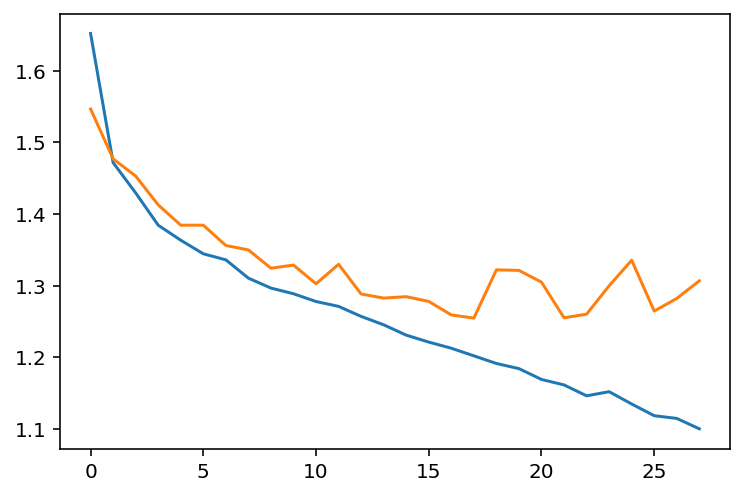

In [39]:
fig, ax = plt.subplots()
ax.plot(nnet.history[f'loss'])
ax.plot(nnet.history[f'val_loss'])

In [42]:
r = dict()

r = {# data params
     'rap_input_dims': rap_input_dims, 'rap_output_dims': rap_output_dims,
     'rtma_input_channels': rtma_input_channels, 'goes_input_channels': goes_input_channels,
     # model params
     'n_rap_inputs': n_rap_inputs, 'n_im_inputs': n_im_inputs, 'n_units_in_conv_layers': n_units_in_conv_layers,
     'kernels_size_and_stride': kernels_size_and_stride, 'rap_activation': rap_activation, 'optim': optim, 
     'lr': lr, 'loss_f': loss, 'n_epochs': n_epochs, 'batch_size': batch_size, 'batchnorm': batchnorm, 
     'dropout': dropout, 'regularization': regularization}

# metrics from nnet.model.history
for key, val in nnet.history.items():
    r[key] = val

TEMP, DEWPT = 0, 1
sets = ['test']

for j, (Xr, Xi, T, RAP, RAOB) in enumerate([(Xer, Xei, Te, RAPtest , RAOBtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X)
    Y = Y.reshape(Y.shape[0], -1)
    T = T.reshape(T.shape[0], -1)
    
    surface_error=25
    r[f'ml_total_{sets[j]}_rmse'] = ml.rmse(Y, T)
    r[f'ml_total_{sets[j]}_rmse_sfc'] = ml.rmse(Y[:,surface_error*2], T[:,surface_error*2])

    Y = Y.reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,TEMP], 
                                                                   RAOB[:, :, 1], 
                                                                   surface_error)
    r[f'ml_temperature_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,DEWPT], 
                                                                   RAOB[:, :, 2], 
                                                                   surface_error)
    r[f'ml_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
    
df = pd.DataFrame([r])

In [44]:
df.to_csv('/mnt/data1/stock/mlsoundings/results/tmae_alley_skip_model_temperature_dewpoint.csv', index=False)

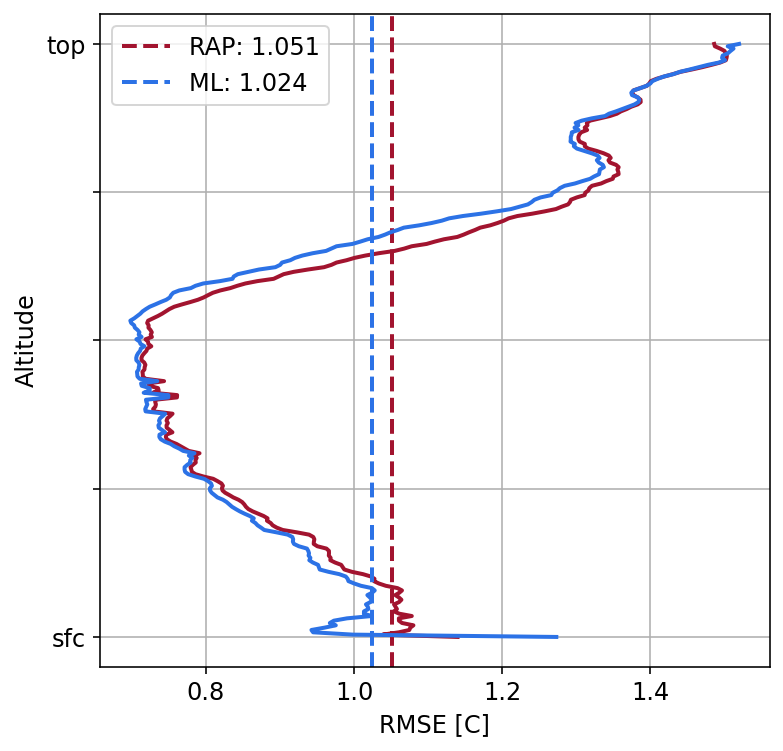

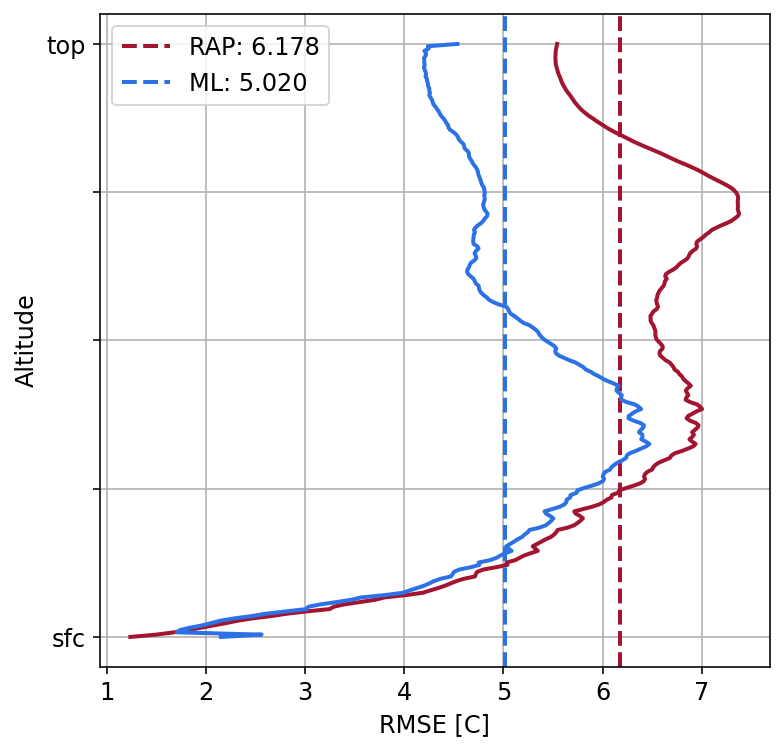

In [41]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(df.iloc[i][f'ml_{v}_{data_set}_rmse'])
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)
#     , title=f'{v.capitalize()} Profile Error',
#                                                file_name=f'/home/stock/research/media/unet_{v}_mse_tpw_loss_{data_set}.pdf')